<a href="https://colab.research.google.com/github/Khoawawa/text-summarization/blob/main/text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALL DEPENDENCIES

In [1]:
!pip install -U transformers # huggingface models library
!pip install -U datasets # huggingface dataset library
!pip install -U accelerate # enhanced calculating library
!pip install -U evaluate # evaluate models library
!pip install -U requests # http request library
!pip install -U bs4 #parsing HTML library
!pip install -U bert-score #bert score library
!pip install -U torch # pytorch for device specification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 10.6 MB/s eta 0:00:00
  Attempt

LOAD BART-LARGE-CNN MODEL AND CNN_DAILYMAIL TEST DATASET FOR EVALUATION

In [2]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset

In [4]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [5]:
ds_test = load_dataset("abisee/cnn_dailymail","3.0.0", split = "test")

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

SUMMARIZATION FUNCTION

In [6]:
def summarize(text,max_length=250,min_length=30):
    tokenized_text = tokenizer(text,
                               max_length = 1024,
                               padding = "max_length",
                               truncation = True,
                               return_tensors = "pt"
                               ).to(device)

    output = model.generate(
        tokenized_text["input_ids"],
        max_length = max_length,
        min_length = min_length
        )

    summary = tokenizer.decode(output[0], skip_special_tokens=True)

    return summary


In [23]:
bart_summaries = []
ref_summaries = []
no_eval_articles = 50

for i in range(no_eval_articles):
    article = ds_test[i]['article']
    summary = ds_test[i]['highlights']
    # SUMMARIZE
    bart_summary = summarize(article)

    bart_summaries.append(bart_summary)
    ref_summaries.append(summary)

In [24]:
from evaluate import load

bert_score = load("bertscore")

results = bert_score.compute(predictions=bart_summaries, references=ref_summaries, model_type="facebook/bart-large-cnn")
score = {
    'f1': results['f1'],
    'precision':results['precision'],
    'recall': results['recall']
}

In [25]:
import numpy as np

print(f"F1: {np.average(score['f1'])}")
print(f"Precisions: {np.average(score['precision'])}")
print(f"Recall: {np.average(score['recall'])}")

F1: 0.6031186974048615
Precisions: 0.6171981191635132
Recall: 0.5914435803890228


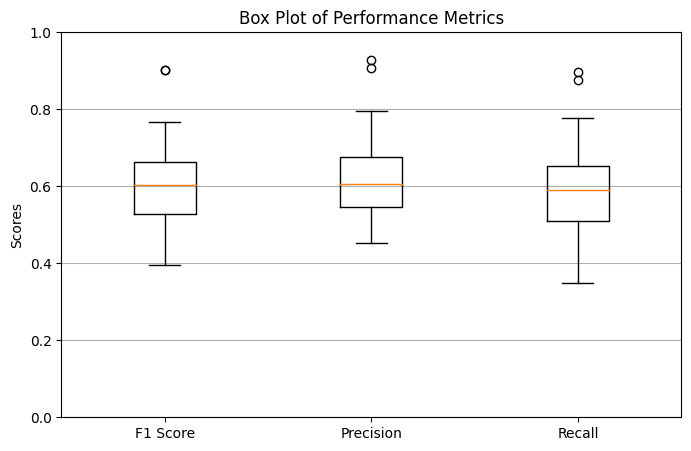

In [26]:
import matplotlib.pyplot as plt
# Prepare the data for box plot
data = [results['f1'], results['precision'], results['recall']]
labels = ['F1 Score', 'Precision', 'Recall']

# Create a box plot
plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=labels)

# Adding labels and title
plt.title('Box Plot of Performance Metrics')
plt.ylabel('Scores')
plt.ylim(0, 1)  # Set y-axis limits
plt.grid(axis='y')
plt.show()

GET DATA FROM CNN WEBSITE AND SUMMARIZE IT

In [27]:
import requests
from bs4 import BeautifulSoup

def scrape_cnn_article(url):
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")

        # For CNN articles
        if "cnn.com" in url:
            title = soup.find('h1').get_text()
            article_body = soup.find_all('p', class_="paragraph inline-placeholder vossi-paragraph")
            content = " ".join([p.get_text() for p in article_body])
            return title, content
        else:
            return None,None

    else:
        print(f"Failed to retrieve the article. Status code: {response.status_code}")
        return None, None

In [28]:
title, content = scrape_cnn_article("https://edition.cnn.com/2024/10/20/politics/mcdonalds-donald-trump-pennsylvania/index.html")

data ={
    'title': title,
    'article': content,
}

In [29]:
cnn_summary = summarize(data['article'])

In [30]:
print(cnn_summary)

Donald Trump stopped by a McDonald’s in Pennsylvania during his Sunday swing. He handed customers food through the drive-thru window, telling them he had made it himself. It's the same job Vice President Kamala Harris has said she held as a young woman. Trump has grown fixated on Harris’ employment there.
